In [1]:
# https://matthew-parker.rbind.io/post/2021-01-16-pytorch-keras-clustering/
import numpy as np  # numpy for math
import pandas as pd       # for dataframes and csv files
import matplotlib.pyplot as plt  # for plotting
from matplotlib import animation  # animate 3D plots
from mpl_toolkits.mplot3d import Axes3D  # 3D plots

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import manifold

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras

In [2]:
games = pd.read_csv("games.csv")
games.head(3) # look at top 3 items
games.shape   # what is the size of the data?

(66314, 17)

In [3]:
games.sort_values(by="Positive", ascending=False)
games = games.head(5000)

In [4]:
games_features = games.copy().dropna()

In [5]:
games_features.pop("HeaderImage")
g_labels = games_features.pop("AppID")

In [6]:
inputs = {}
for name, column in games_features.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32
    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'Name': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Name')>,
 'ReleaseDate': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'ReleaseDate')>,
 'Price': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Price')>,
 'AboutTheGame': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'AboutTheGame')>,
 'Positive': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Positive')>,
 'Negative': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Negative')>,
 'AveragePlaytimeForever': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'AveragePlaytimeForever')>,
 'AveragePlaytime2W': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'AveragePlaytime2W')>,
 'MedianPlaytimeForever': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'MedianPlaytimeForever')>,
 'MedianPlaytime2W': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'MedianPlaytime2W')>,
 'Developers': <KerasTens

In [7]:
# deal with numeric features
numeric_inputs = {name: input for name, input in inputs.items() if input.dtype == tf.float32}

x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(games_features[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)
preprocessed_inputs = [all_numeric_inputs]

all_numeric_inputs

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'normalization')>

In [8]:
# deal with string features
for name, input in inputs.items():
    if input.dtype != tf.string:
        continue

    lookup = preprocessing.StringLookup(vocabulary=np.unique(games_features[name]))
    one_hot = preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x) # append preprocessed feature to features list
    
preprocessed_inputs

[<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'normalization')>,
 <KerasTensor: shape=(None, 4740) dtype=float32 (created by layer 'category_encoding')>,
 <KerasTensor: shape=(None, 1818) dtype=float32 (created by layer 'category_encoding_1')>,
 <KerasTensor: shape=(None, 4737) dtype=float32 (created by layer 'category_encoding_2')>,
 <KerasTensor: shape=(None, 2962) dtype=float32 (created by layer 'category_encoding_3')>,
 <KerasTensor: shape=(None, 2083) dtype=float32 (created by layer 'category_encoding_4')>,
 <KerasTensor: shape=(None, 1331) dtype=float32 (created by layer 'category_encoding_5')>,
 <KerasTensor: shape=(None, 416) dtype=float32 (created by layer 'category_encoding_6')>,
 <KerasTensor: shape=(None, 4535) dtype=float32 (created by layer 'category_encoding_7')>]

In [9]:
preprocessed_inputs_cat = keras.layers.Concatenate()(preprocessed_inputs)
preprocessing_layer = tf.keras.Model(inputs, preprocessed_inputs_cat, name="ProcessData")

# this saves an image of the model, see note regarding plot_model issues
tf.keras.utils.plot_model(model=preprocessing_layer, rankdir="LR", dpi=130, show_shapes=True, to_file="processing.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [10]:
games_features_dict = {name: np.array(value) for name, value in games_features.items()}

# grab two samples
two_sample_dict = {name:values[1:3, ] for name, values in games_features_dict.items()}
two_sample_dict

{'Name': array(['Team Fortress Classic', 'Day of Defeat'], dtype=object),
 'ReleaseDate': array(['1-Apr-99', '1-May-03'], dtype=object),
 'Price': array([4.99, 4.99]),
 'AboutTheGame': array(['One of the most popular online action games of all time, Team Fortress Classic features over nine character classes -- from Medic to Spy to Demolition Man -- enlisted in a unique style of online team warfare. Each character class possesses unique weapons, items, and abilities, as teams compete online in a variety of game play modes.',
        'Enlist in an intense brand of Axis vs. Allied teamplay set in the WWII European Theatre of Operations. Players assume the role of light/assault/heavy infantry, sniper or machine-gunner class, each with a unique arsenal of historical weaponry at their disposal. Missions are based on key historical operations. And, as war rages, players must work together with their squad to accomplish a variety of mission-specific objectives.'],
       dtype=object),
 'Posit

In [11]:
# apply the preprocessing layer
two_sample_fitted = preprocessing_layer(two_sample_dict)

two_sample_fitted

<tf.Tensor: shape=(2, 22629), dtype=float32, numpy=
array([[-0.48900947, -0.01909257, -0.0064706 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.48900947, -0.02437995, -0.03438325, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)>

In [12]:
# This is the size of our input data
full_dim = two_sample_fitted.shape.as_list()[1]

# these are the downsampling/upsampling dimensions
encoding_dim1 = 128
encoding_dim2 = 16
encoding_dim3 = 4 # we will use these 3 dimensions for clustering

# This is our encoder input
encoder_input_data = keras.Input(shape=(full_dim,))

# the encoded representation of the input
encoded_layer1 = keras.layers.Dense(encoding_dim1, activation='relu')(encoder_input_data)
encoded_layer2 = keras.layers.Dense(encoding_dim2, activation='relu')(encoded_layer1)
# Note that encoded_layer3 is our 3 dimensional "clustered" layer, which we will later use for clustering
encoded_layer3 = keras.layers.Dense(encoding_dim3, activation='relu', name="ClusteringLayer")(encoded_layer2)

encoder_model = keras.Model(encoder_input_data, encoded_layer3, name="Encoder")

# This is our decoder input
decoder_input_data = keras.Input(shape=(encoding_dim3,))
# the reconstruction of the input
decoded_layer2 = keras.layers.Dense(encoding_dim2, activation='relu')(decoder_input_data)
decoded_layer1 = keras.layers.Dense(encoding_dim1, activation='relu')(decoded_layer2)
decoded_layer0 = keras.layers.Dense(full_dim, activation='sigmoid')(decoded_layer1)

# This model maps an input to its autoencoder reconstruction
decoder_model = keras.Model(decoder_input_data, decoded_layer0, name="Decoder")

# connect the encoder and decoder models
autoencoder_output = decoder_model(encoder_model(encoder_input_data))

# create the autoencoder model
autoencoder_model = keras.Model(encoder_input_data, autoencoder_output, name="Autoencoder")

# compile the model
autoencoder_model.compile(optimizer="RMSprop", loss=tf.keras.losses.mean_squared_error)

# plot the model
tf.keras.utils.plot_model(model=autoencoder_model, rankdir="LR", dpi=130, show_shapes=True, to_file="autoencoder.png")


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
# process the inputs
g_items = preprocessing_layer(games_features_dict)

# split into training and testing sets (80/20 split)
train_data, test_data, train_labels, test_labels = train_test_split(g_items.numpy(), g_labels, train_size=0.8, random_state=5)

# fit the model using the training data
history = autoencoder_model.fit(train_data, train_data, epochs=500, batch_size=256, shuffle=True, validation_data=(test_data, test_data), validation_freq=1)

Epoch 1/500
15/15 [==============================] - 2s 116ms/step - loss: 0.2503 - val_loss: 0.2501
Epoch 2/500
15/15 [==============================] - 2s 112ms/step - loss: 0.2501 - val_loss: 0.2499
Epoch 3/500
15/15 [==============================] - 2s 114ms/step - loss: 0.2500 - val_loss: 0.2498
Epoch 4/500
15/15 [==============================] - 2s 114ms/step - loss: 0.2499 - val_loss: 0.2497
Epoch 5/500
15/15 [==============================] - 2s 122ms/step - loss: 0.2497 - val_loss: 0.2496
Epoch 6/500
15/15 [==============================] - 2s 114ms/step - loss: 0.2496 - val_loss: 0.2494
Epoch 7/500
15/15 [==============================] - 2s 110ms/step - loss: 0.2495 - val_loss: 0.2493
Epoch 8/500
15/15 [==============================] - 2s 118ms/step - loss: 0.2494 - val_loss: 0.2492
Epoch 9/500
15/15 [==============================] - 2s 139ms/step - loss: 0.2492 - val_loss: 0.2490
Epoch 10/500
15/15 [==============================] - 2s 114ms/step - loss: 0.2491 - val_lo

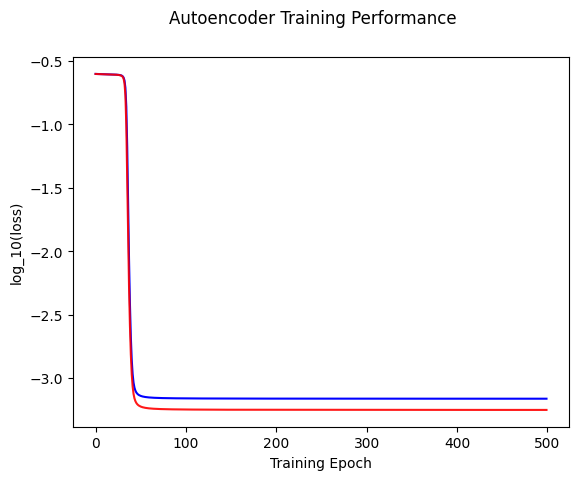

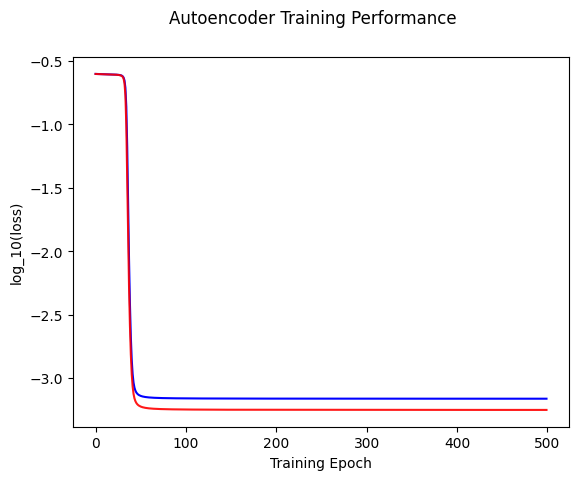

In [15]:
# Investigate training performance:
history_fig, (ax2) = plt.subplots(1, sharex=True)
history_fig.suptitle('Autoencoder Training Performance')
#ax1.plot(range(0,1000), history.history['accuracy'], color='blue')
#ax1.set(ylabel='Reconstruction Accuracy')
ax2.plot(range(0,500), np.log10(history.history['loss']), color='blue')
ax2.plot(range(0,500), np.log10(history.history['val_loss']), color='red', alpha=0.9)
ax2.set(ylabel='log_10(loss)', xlabel='Training Epoch')
history_fig

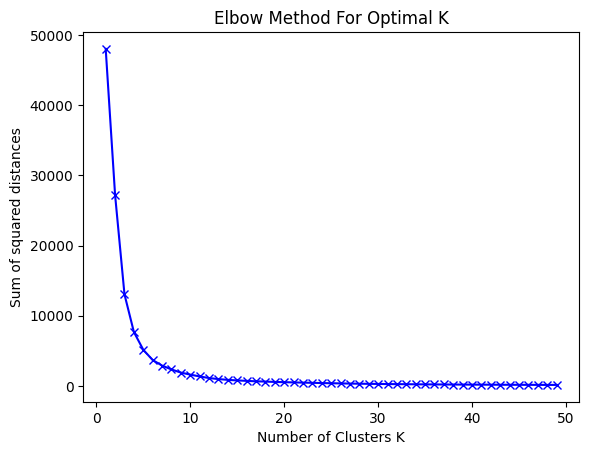

In [16]:
encoded_items = encoder_model(g_items)

# choose number of clusters K:
Sum_of_squared_distances = []
K = range(1, 50)
for k in K:
    km = KMeans(init='k-means++', n_clusters=k, n_init=10)
    km.fit(encoded_items)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
#plt.xlim(180, 200)
#plt.ylim(0, 20)

plt.xlabel('Number of Clusters K')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal K')
plt.show()

In [17]:
print(Sum_of_squared_distances)

[48013.369197901746, 27192.060503744357, 13035.131721160424, 7678.089902108553, 5147.8711003119215, 3680.098874010208, 2895.095520250959, 2343.261412620786, 1896.4976404904905, 1607.011718781336, 1347.5245872148346, 1116.803777880509, 971.1182662554972, 858.0781350025821, 779.8195796788794, 715.7817146493526, 650.8335567427359, 614.129559737274, 563.6509999002036, 529.5680354729787, 496.4460019717047, 464.1543519557022, 436.6806595737077, 402.6323286985071, 377.9367806427713, 356.43483622745197, 328.89460376255374, 310.833824610954, 292.9564266172549, 276.96463430744575, 261.0189343614955, 248.87201384544085, 240.9632342964519, 225.43568322600416, 215.5493310659648, 207.866719379922, 201.60262901027488, 192.2621275562951, 188.32878241535897, 178.76477024986536, 175.69198835913554, 169.24736865126405, 161.9850766312816, 158.6926353812916, 152.1208429358555, 148.74675454503665, 144.70907200563934, 138.79510353255435, 137.806100470163]


In [18]:
kmeans = KMeans(init='k-means++', n_clusters=50, n_init=10)
kmeans.fit(encoded_items)
P = kmeans.predict(encoded_items)

In [19]:
print(encoded_items)

tf.Tensor(
[[17.04139    3.813683   6.511949  15.157103 ]
 [14.62466    4.996339   5.881962  13.442959 ]
 [14.603764   4.8633275  5.84609   13.403233 ]
 ...
 [12.603836   4.3990464  5.149786  11.647793 ]
 [13.781341   4.72763    5.6143003 12.712715 ]
 [11.880995   4.1497297  4.8267875 11.052094 ]], shape=(4796, 4), dtype=float32)


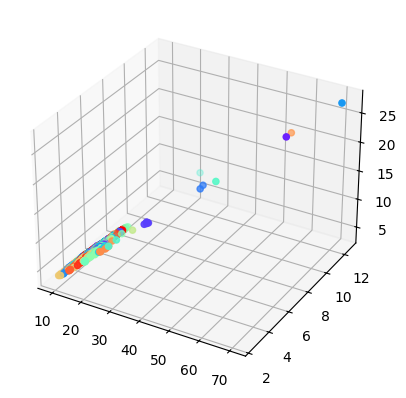

In [21]:
# visualize the clusters:
%matplotlib inline  
fig = plt.figure()

ax = plt.axes(projection='3d')
ax.scatter3D(encoded_items[:,0], encoded_items[:,1], encoded_items[:,2], c=P, marker="o", picker=True, cmap="rainbow");
#plt.colorbar(p, shrink=0.5)
plt.show()

def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('kmeans_fig.gif', writer=animation.PillowWriter(fps=12))

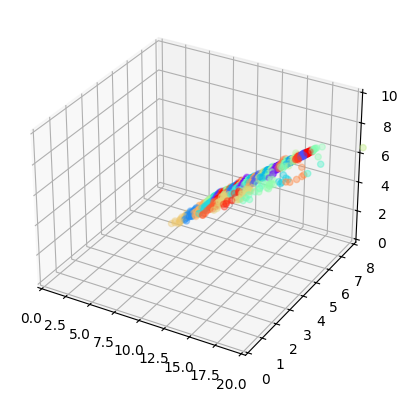

In [22]:
# visualize the clusters:
%matplotlib inline  
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.scatter3D(encoded_items[:,0], encoded_items[:,1], encoded_items[:,2], c=P, marker="o", picker=True, cmap="rainbow")
ax.axes.set_xlim3d(left=0, right=20) 
ax.axes.set_ylim3d(bottom=0, top=8) 
ax.axes.set_zlim3d(bottom=0, top=10) 
#plt.colorbar(p, shrink=0.5)
plt.show()

def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('kmeans_fig2.gif', writer=animation.PillowWriter(fps=12))

In [23]:
from sklearn.neighbors import NearestNeighbors

In [102]:
def get_recommendations(game, encoded, df):
    knn = NearestNeighbors(n_neighbors=7, metric="l2")
    knn.fit(encoded)
    try:
        i = df[df['Name'] == game].index[0]
        neighbors = knn.kneighbors(np.array(encoded[i]).reshape(1, 4), return_distance=False)
        recs = []
        for g in neighbors:
            recs.append(df['Name'].iloc[g].values.tolist())
        return recs[0][1:]
    except:
        pass

In [103]:
input_game = "Dota 2"
recs = get_recommendations(input_game, encoded_items, games_features)
for r in recs:
    print(r)

Jagged Alliance 1: Gold Edition
Project AURA
Brigade E5: New Jagged Union
Aartform Curvy 3D 3.0
Gloria Victis: Medieval MMORPG
FINAL FANTASY XIV Online


In [91]:
def get_recs_lst(games, encoded_items, df):
    input_games = [game.strip() for game in games.split('@@@')]

    recs = set()
    g_set = set()

    for g in input_games:
        
        try:
            game_index = df[df['Name'] == g].index[0]
            g_set.add(g)
            r = get_recommendations(g, encoded_items, df)
            for rec in r:
                recs.add(rec)
        except:
            pass
    return recs, g_set

In [92]:
def evaluate(recs, user_games, num_games):
    tp = 0
    fp = 0
    for rec in recs:
        if rec in user_games:
            tp += 1
        else:
            fp += 1
    fn = 0
    for ug in user_games:
        if ug not in recs:
            fn += 1
    tn = num_games - tp - fp - fn
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    try:
        f = (2 * p * r)/(p + r)
    except:
        f = 0
    a = (tp + tn) / (tp + fn + tn + fp)
    return p, r, f, a

In [105]:
udf = pd.read_csv("user_games.csv")
udf.columns = ["Id", "Games"]

e_lst = []
count = 0

for i, row in udf.iterrows():
    r = get_recs_lst(row['Games'], encoded_items, games_features)
    if len(r[0]) != 0:
        e = evaluate(r[0], r[1], len(games_features))
        e_lst.append(e)

print(e_lst)

[(0.015151515151515152, 0.09090909090909091, 0.025974025974025976, 0.9843619683069225), (0.0, 0.0, 0, 0.9866555462885738), (0.030181086519114688, 0.16666666666666666, 0.05110732538330494, 0.8838615512927439), (0.0, 0.0, 0, 0.9985404503753128), (0.027777777777777776, 0.16666666666666666, 0.04761904761904762, 0.9916597164303587), (0.0, 0.0, 0, 0.9841534612176814), (0.0, 0.0, 0, 0.994161801501251), (0.0, 0.0, 0, 0.9956213511259383), (0.03333333333333333, 0.16666666666666666, 0.05555555555555555, 0.9929107589658048), (0.004098360655737705, 0.023809523809523808, 0.006993006993006993, 0.9407839866555463), (0.03896103896103896, 0.21649484536082475, 0.0660377358490566, 0.8761467889908257), (0.0, 0.0, 0, 0.9868640533778148), (0.0, 0.0, 0, 0.9970809007506255), (0.023809523809523808, 0.14285714285714285, 0.04081632653061224, 0.9902001668056714), (0.0, 0.0, 0, 0.9970809007506255), (0.0, 0.0, 0, 0.9985404503753128), (0.0, 0.0, 0, 0.9970809007506255), (0.0, 0.0, 0, 0.9843619683069225), (0.0, 0.0, 0,

In [106]:
p = 0
r = 0
f = 0
a = 0
for prfa in e_lst:
    p += prfa[0]
    r += prfa[1]
    f += prfa[2]
    a += prfa[3]
p = p/len(e_lst)
r = r/len(e_lst)
f = f/len(e_lst)
a = a/len(e_lst)

print("Avg precision: {}".format(p))
print("Avg recall: {}".format(r))
print("Avg f1: {}".format(f))
print("Avg accuracy: {}".format(a))

Avg precision: 0.007566874860640147
Avg recall: 0.04398843284273924
Avg f1: 0.012909554241463533
Avg accuracy: 0.9852466404239851
